# 基于Mask-R-CNN训练自定义数据集

## 配置环境

In [1]:
cd /content/drive/MyDrive/mask rcnn_test

/content/drive/MyDrive/mask rcnn_test


In [2]:
!pip uninstall tensorflow --yes

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0


In [3]:
!pip uninstall PyYAML --yes

Found existing installation: PyYAML 3.13
Uninstalling PyYAML-3.13:
  Successfully uninstalled PyYAML-3.13


In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 345.0 MB 14 kB/s 
     |████████████████████████████████| 20.0 MB 1.4 MB/s 
     |████████████████████████████████| 3.0 MB 44.0 MB/s 
     |████████████████████████████████| 276 kB 61.1 MB/s 
     |████████████████████████████████| 2.9 MB 45.7 MB/s 
     |████████████████████████████████| 636 kB 54.9 MB/s 
     |████████████████████████████████| 3.2 MB 43.1 MB/s 
     |████████████████████████████████| 50 kB 5.0 MB/s 
     |████████████████████████████████| 367 kB 69.5 MB/s 
     |████████████████████████████████| 154 kB 69.2 MB/s 
     |████████████████████████████████| 199 kB 68.8 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation:

In [ ]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.2
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.0.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [2]:
cd /content/drive/MyDrive/mask rcnn_test

/content/drive/MyDrive/mask rcnn_test


## 导入相关包

In [29]:
# -*- coding: utf-8 -*-

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import tensorflow as tf
from mrcnn.config import Config
#import utils
from mrcnn import model as modellib,utils
from mrcnn import visualize
import yaml
from mrcnn.model import log
from PIL import Image
"""
加入自己类别名称
更改类别个数
"""

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Root directory of the project
ROOT_DIR = os.getcwd()

#ROOT_DIR = os.path.abspath("../")
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
%matplotlib inline 
iter_num=0

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "saved_weight/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


## Configuration

In [1]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8 * 6, 16 * 6, 32 * 6, 64 * 6, 128 * 6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 100

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 50


config = ShapesConfig()
config.display()


## Dataset

In [5]:
class DrugDataset(utils.Dataset):
    # 得到该图中有多少个实例（物体）
    def get_obj_index(self, image):
        n = np.max(image)
        return n

    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.load(f.read(), Loader=yaml.FullLoader)
            labels = temp['label_names']
            del labels[0]
        return labels

    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image,image_id):
        info = self.image_info[image_id]
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] = 1
        return mask

    # 重新写load_shapes，里面包含自己的自己的类别
    # 并在self.image_info信息中添加了path、mask_path 、yaml_path
    # yaml_pathdataset_root_path = "/tongue_dateset/"
    # img_floder = dataset_root_path + "rgb"
    # mask_floder = dataset_root_path + "mask"
    # dataset_root_path = "/tongue_dateset/"
    def load_shapes(self, count, img_floder, mask_floder, imglist, dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        #self.add_class("shapes", 1, "tank") # 黑色素瘤
        #
        self.add_class("shapes", 1, "category1") 
        self.add_class("shapes", 2, "category2")  

        for i in range(count):
            # 获取图片宽和高

            filestr = imglist[i].split(".")[0]
            
            mask_path = mask_floder + "/" + filestr + ".png"
            yaml_path = dataset_root_path + "labelme_json/" + filestr + "_json/info.yaml"
            print(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")
            cv_img = cv2.imread(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")

            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                           width=cv_img.shape[1], height=cv_img.shape[0], mask_path=mask_path, yaml_path=yaml_path)

    # 重写load_mask
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        print("image_id",image_id)
        info = self.image_info[image_id]
        count = 1  # number of object
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img,image_id)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion

            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels = []
        labels = self.from_yaml_get_class(image_id)
        labels_form = []
        for i in range(len(labels)):
            if labels[i].find("category1") != -1:
                labels_form.append("category1")
            if labels[i].find("category2") != -1:
                labels_form.append("category2")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)


## Notebook preference

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax


## 路径

In [7]:
#基础设置
dataset_root_path="dataset/category_dataset"
img_floder = dataset_root_path + "pic"
mask_floder = dataset_root_path + "cv2_mask"
imglist = os.listdir(img_floder)
count = len(imglist)

## 准备数据集

In [8]:
#train与val数据集准备
dataset = DrugDataset()
dataset.load_shapes(count, img_floder, mask_floder, imglist,dataset_root_path)
dataset.prepare()

print("dataset-->",dataset._image_ids)


print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

mydata/labelme_json/1_json/img.png
mydata/labelme_json/10_json/img.png
mydata/labelme_json/15_json/img.png
mydata/labelme_json/14_json/img.png
mydata/labelme_json/11_json/img.png
mydata/labelme_json/17_json/img.png
mydata/labelme_json/18_json/img.png
mydata/labelme_json/16_json/img.png
mydata/labelme_json/12_json/img.png
dataset--> [0 1 2 3 4 5 6 7 8]
Image Count: 9
Class Count: 3
  0. BG                                                
  1. category1                                         
  2. category2                                         


image_id 8


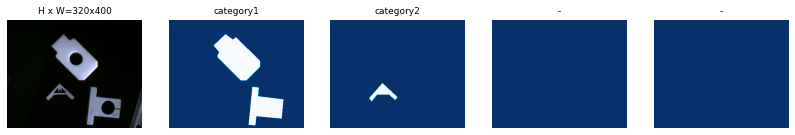

image_id 8


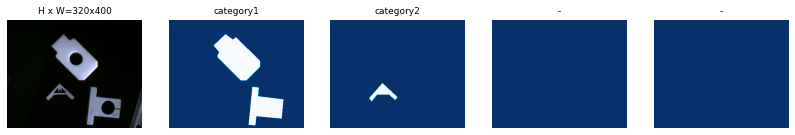

image_id 1


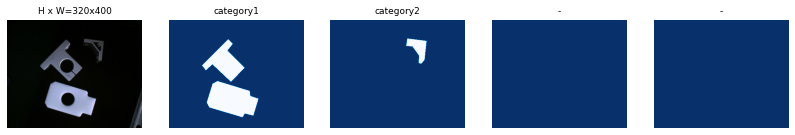

image_id 8


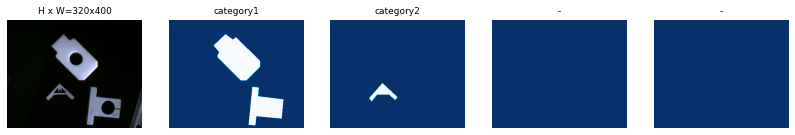

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## 边界框
我们不是使用源数据集提供的边界框坐标，而是从蒙版计算边界框。这允许我们一致地处理边界框，而不管源数据集是什么，这也使它更容易

image_id 2
image_id  2 
image                    shape: (320, 400, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (320, 400, 2)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (2,)                  min:    1.00000  max:    2.00000  int32
bbox                     shape: (2, 4)                min:   63.00000  max:  349.00000  int32


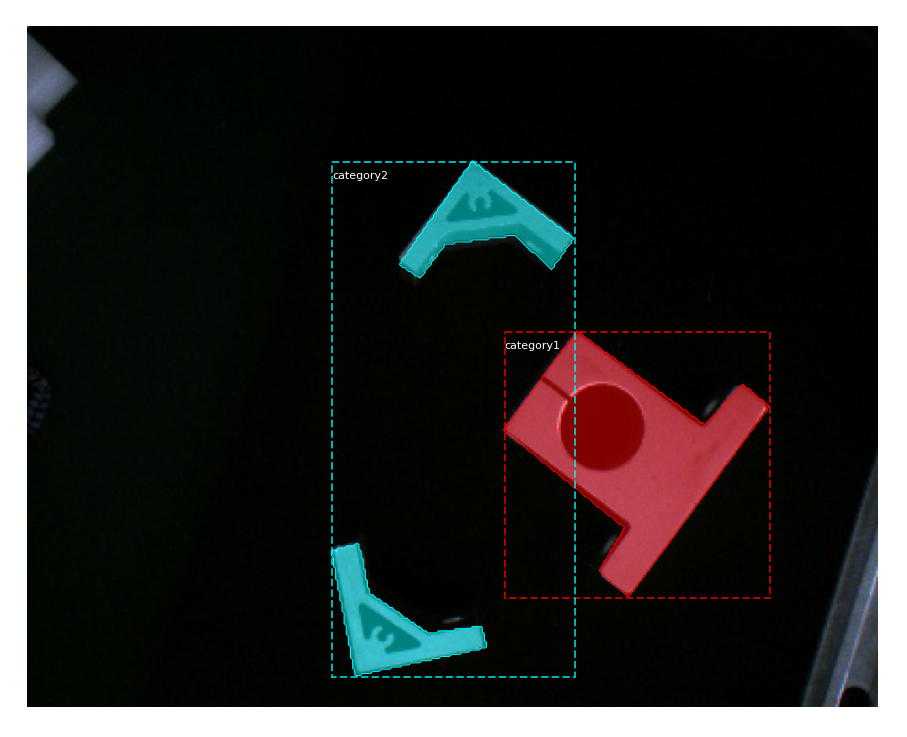

In [10]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images
为了支持每批处理多个图像，图像被调整为一个大小(1024x1024)。但纵横比保留了下来。如果一个图像不是正方形的，那么在顶部/底部或右侧/左侧添加零填充。

image_id 3
image_id:  3 
Original shape:  (320, 400, 3)
image                    shape: (384, 384, 3)         min:    0.00000  max:  252.00000  uint8
mask                     shape: (384, 384, 2)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (2,)                  min:    1.00000  max:    2.00000  int32
bbox                     shape: (2, 4)                min:  116.00000  max:  313.00000  int32


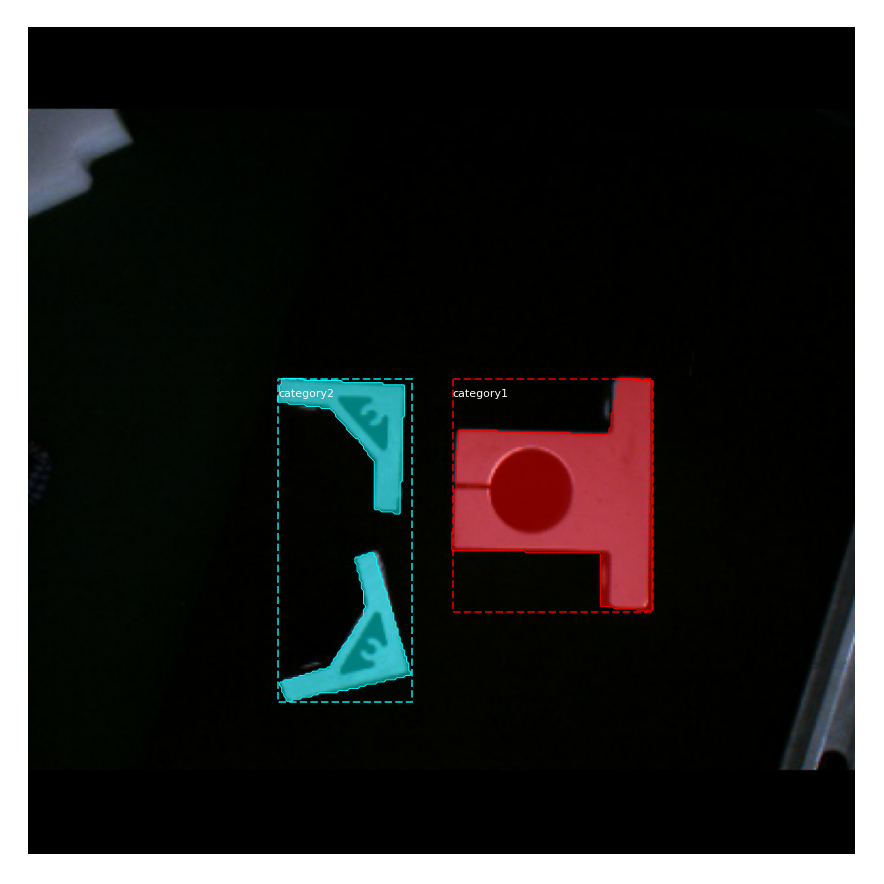

In [13]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks

在使用高分辨率图像进行训练时，实例二值掩码（mask）会变大。例如，如果使用1024x1024的图像进行训练，那么单个实例的掩码需要1MB的内存(Numpy使用字节表示布尔值)。如果一张图像有100个实例，那么仅掩码就需要100MB。

为了提高训练速度，我们通过以下方法优化mask:

- 我们存储对象边界框内的mask像素，而不是完整图像的mask。与图像大小相比，大多数对象都很小，因此我们不会在对象周围存储大量的零，从而节省空间。
- 我们将mask调整为较小的尺寸(例如56x56)。对于大于所选尺寸的对象，我们会失去一些准确性。但是大多数对象的标注一开始就不是很准确，所以对于大多数实际目的来说，这种损失是可以忽略的。mini_mask的大小可以在配置类中设置。

为了可视化mask调整的效果，并验证代码的正确性，我们可视化了一些示例。

image_id 6
image                    shape: (384, 384, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  400.00000  float64
class_ids                shape: (2,)                  min:    1.00000  max:    2.00000  int32
bbox                     shape: (2, 4)                min:   90.00000  max:  331.00000  int32
mask                     shape: (384, 384, 2)         min:    0.00000  max:    1.00000  uint8


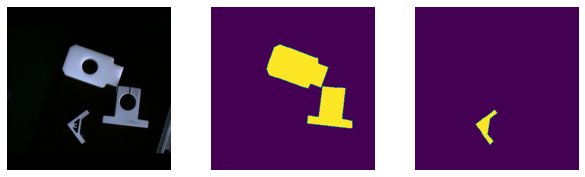

In [22]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

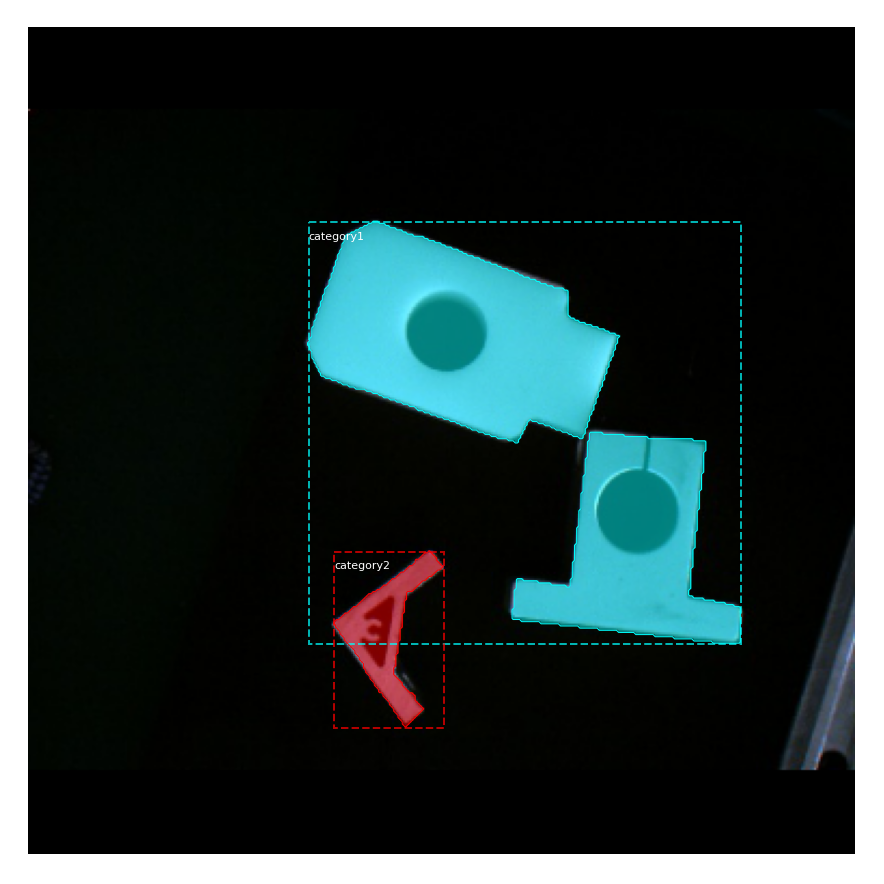

In [23]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image_id 6


mask                     shape: (56, 56, 2)           min:    0.00000  max:    1.00000  bool


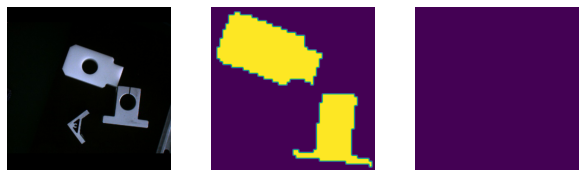

In [24]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
visualize.display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

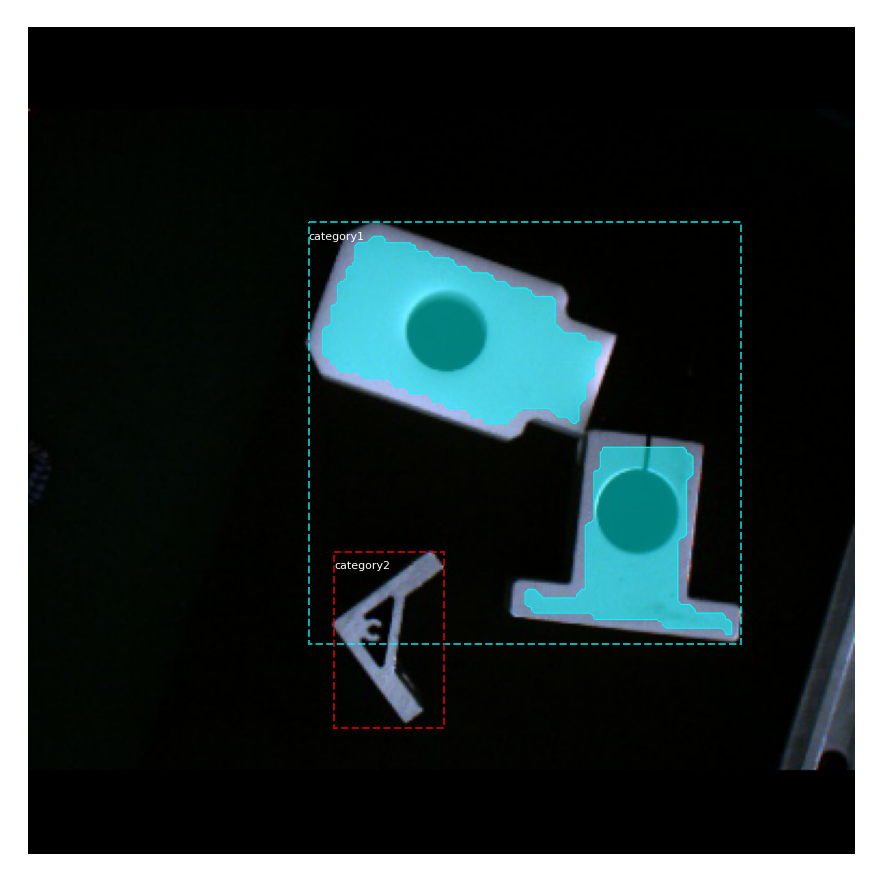

In [25]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

The order of anchors is important. Use the same order in training and prediction phases. And it must match the order of the convolution execution.

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:**
In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature meap of the first layer is 256x256, which generates about 200K anchors (256*256*3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example. 

In this implementation we use an anchor stride of 2, which is different from the paper.

In [27]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  36828
Scales:  (48, 96, 192, 384, 768)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 27648
Anchors in Level 1: 6912
Anchors in Level 2: 1728
Anchors in Level 3: 432
Anchors in Level 4: 108


image_id 2
Level 0. Anchors:  27648  Feature map Shape: [96 96]
Level 1. Anchors:   6912  Feature map Shape: [48 48]
Level 2. Anchors:   1728  Feature map Shape: [24 24]
Level 3. Anchors:    432  Feature map Shape: [12 12]
Level 4. Anchors:    108  Feature map Shape: [6 6]


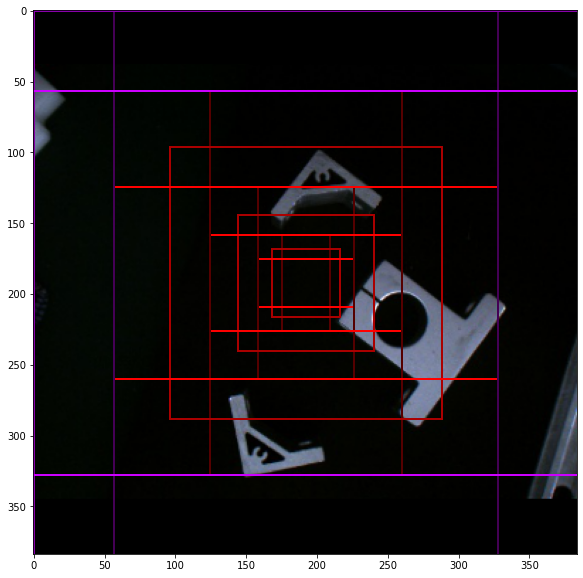

In [30]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generate

In [31]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [32]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

image_id 4
image_id 1
image_id 6
image_id 0
rois                     shape: (4, 100, 4)           min:    0.00000  max:  383.00000  int32
mrcnn_class_ids          shape: (4, 100, 1)           min:    0.00000  max:    2.00000  int32
mrcnn_bbox               shape: (4, 100, 3, 4)        min:   -3.38710  max:    3.02643  float32
mrcnn_mask               shape: (4, 100, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 30)               min:    0.00000  max:    2.00000  int32
gt_boxes                 shape: (4, 30, 4)            min:    0.00000  max:  339.00000  int32
gt_masks                 shape: (4, 56, 56, 30)       min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 36828, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -1.32812  max:    3.33333  float64
image_id:  4 


anchors                  shape: (36828, 4)            min: -543.05801  max:  863.05801  float64
refined_anchors          shape: (9, 4)                min:  103.00000  max:  339.00000  float32
Positive anchors: 9
Negative anchors: 247
Neutral anchors: 36572
BG                     : 67
category1              : 33


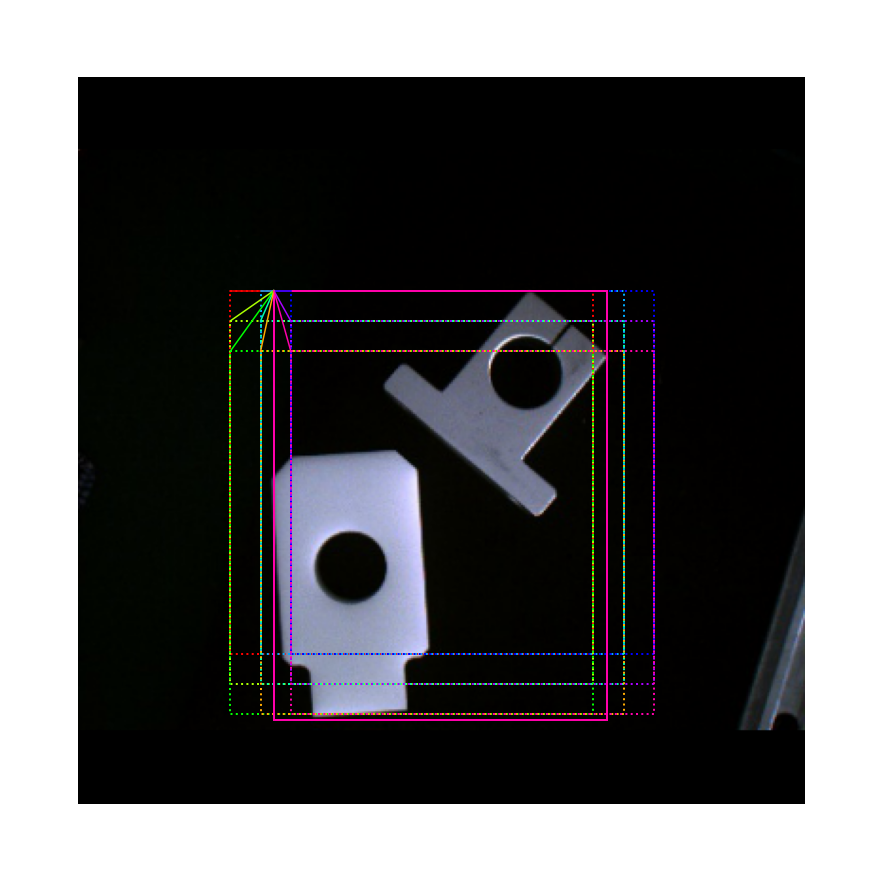

In [33]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

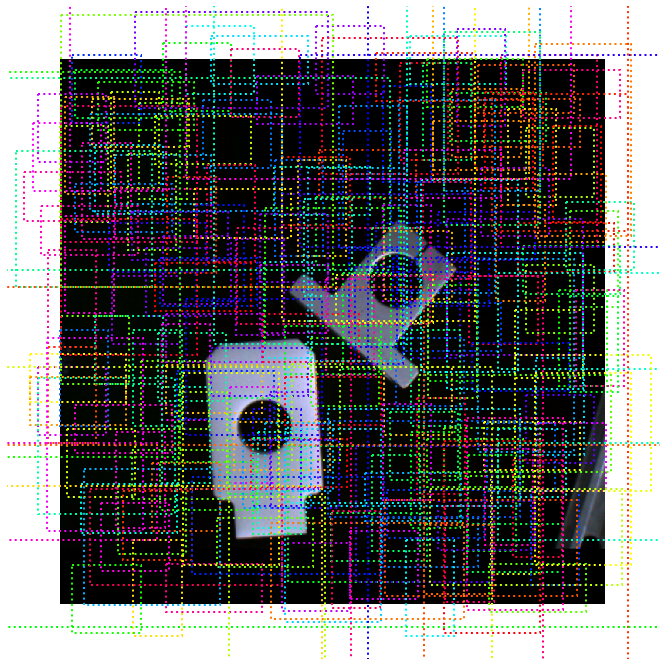

In [34]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

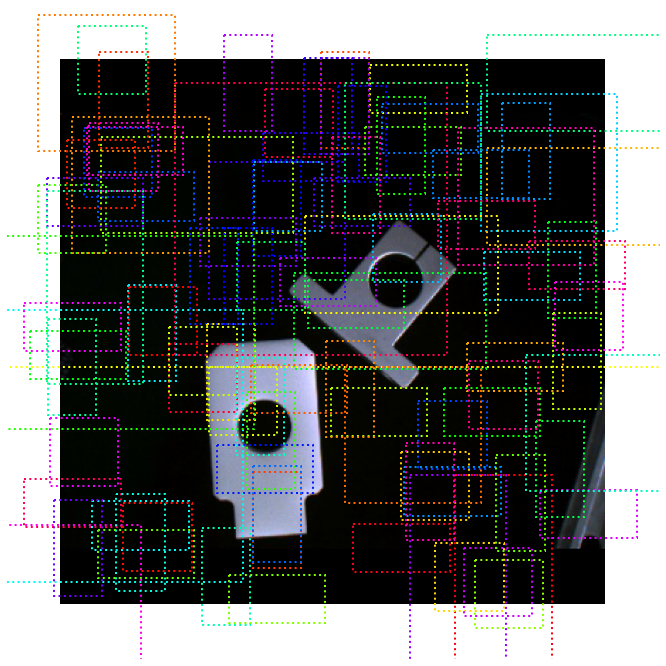

In [35]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  33
Negative ROIs:  67
Positive Ratio: 0.33
Unique ROIs: 100 out of 100


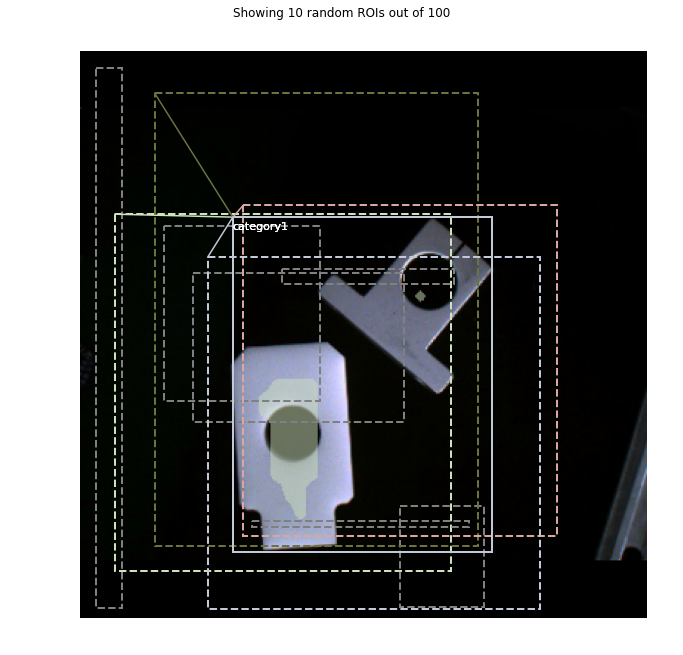

In [36]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

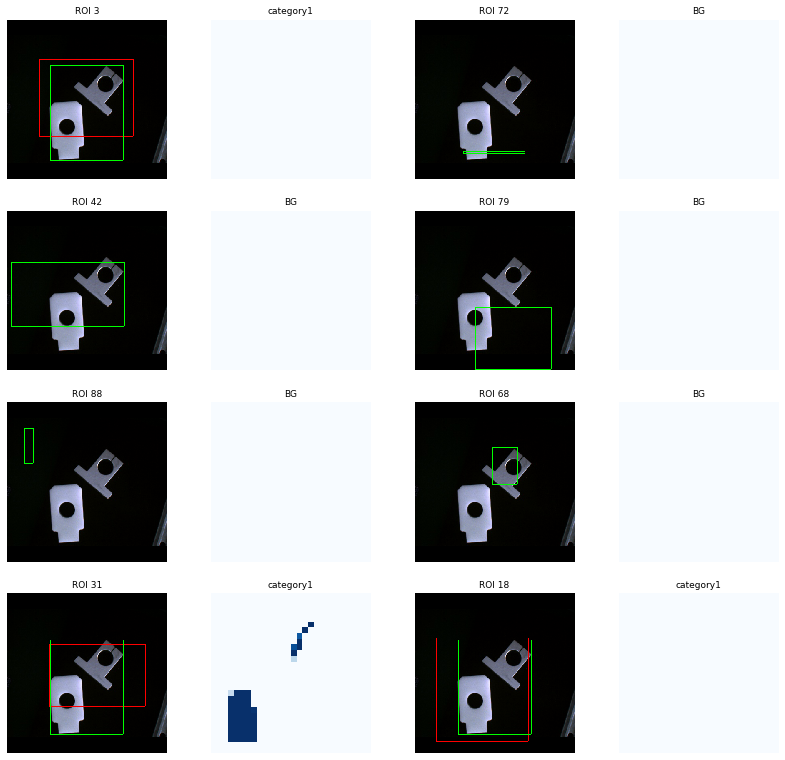

In [38]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    visualize.display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [39]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

image_id 2
   33  0.33
image_id 4
   33  0.33
image_id 8
   33  0.33
image_id 3
   33  0.33
image_id 5
   33  0.33
image_id 1
   33  0.33
image_id 0
   33  0.33
image_id 6
   33  0.33
image_id 7
   33  0.33
image_id 2
   33  0.33
Average percent: 0.33
